# BERT

### Setup and Installation

Installs necessary Python libraries including Hugging Face Transformers, PyTorch, and others. accelerate is used to facilitate training on GPU or CPU.

!pip install accelerate

!pip install transformers torch scikit-learn pandas

### Imports and Environment Setup

Loads necessary modules for data manipulation, neural network operations, text processing, and more. It suppresses warnings to keep the notebook cleaner.

import io
import warnings
import os
import requests
import pandas as pd
import numpy as np
import re
import nltk
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
from io import StringIO

from zipfile import ZipFile
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords  #stopwords
from nltk import word_tokenize,sent_tokenize
import gensim
from gensim.models import Word2Vec
warnings.filterwarnings("ignore")

# Check if CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Data Downloading

Downloads a dataset from a specified URL and loads it into a pandas DataFrame. This is typically used for model training or analysis.




# Define the URL
URL = "https://raw.githubusercontent.com/TalLinzen/rnn_agreement/master/data/wiki.vocab"

# Send a GET request to the URL and get the content
response = requests.get(URL)
if response.status_code == 200:
    # Decode the content and read it into a DataFrame
    content = response.content.decode('utf-8')
    df = pd.read_csv(StringIO(content), sep='\t')
    print(df.head())  # Display the first few rows of the DataFrame
else:
    print("Failed to download data from the URL.")

import requests

# Define the URL of the file to download
URL = "http://tallinzen.net/media/rnn_agreement/rnn_agr_simple.tar.gz"

# Send a GET request to the URL to download the file
response = requests.get(URL)

if response.status_code == 200:
    # Save the downloaded content to a file
    with open("rnn_agr_simple.tar.gz", "wb") as f:
        f.write(response.content)
    print("File downloaded successfully.")
else:
    print("Failed to download the file.")

import tarfile

# Specify the path to the tar.gz file and the directory to extract to
tar_file_path = "/content/rnn_agr_simple.tar.gz"
extract_dir = "/content"

# Open the tar.gz file for reading
with tarfile.open(tar_file_path, "r:gz") as tar:
    # Extract all contents to the specified directory
    tar.extractall(path=extract_dir)
    print("Archive extracted successfully.")

### Dataset Preparation

Loads and prepares the dataset for training by splitting into training and testing sets.


# Load dataset
file_path = '/content/rnn_agr_simple/numpred.train'
column_names = ['POS', 'Preamble']
df = pd.read_csv(file_path, sep='\t', names=column_names)

df.head()

# Map POS tags to numerical labels
label_map = {'VBZ': 0, 'VBP': 1}
df['label'] = df['POS'].map(label_map)

df.head()

from sklearn.model_selection import train_test_split

# Ensuring the training and testing sets have the same proportion of classes as the original dataset
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42, stratify=df['label'])


### Tokenization and Dataset Creation

Tokenizes text data using a BERT tokenizer, preparing it for input into a BERT model.

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_data(df):
    return tokenizer(df['Preamble'].tolist(), padding="max_length", truncation=True, max_length=128, return_tensors="pt")

train_encodings = tokenize_data(train_df)
test_encodings = tokenize_data(test_df)


train_labels = torch.tensor(train_df['label'].values)
test_labels = torch.tensor(test_df['label'].values)

train_labels.shape


test_labels.shape

from torch.utils.data import Dataset

class VerbFormDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = VerbFormDataset(train_encodings, train_labels)
test_dataset = VerbFormDataset(test_encodings, test_labels)


from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }



### Model Initialization and Training Setup

Initializes a BERT model for sequence classification, sets up training arguments, and begins training.

from transformers import BertForSequenceClassification, BertTokenizer

# Initialize tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)  # Ensure num_labels matches your task

# Check if CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move model to the correct device


model

from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",  # Evaluates at the end of each epoch
    save_strategy="epoch",        # Saves at the end of each epoch
    load_best_model_at_end=True,  # Loads the best model at the end based on the metric
    metric_for_best_model='loss', # Change this to the metric you are monitoring
    fp16=True                     # Enable mixed precision
)

from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics  # Ensure you define a function to compute metrics
)


trainer.train()


# Specify the save directory
save_directory = "./model_save_directory"

# Save the trained model and the tokenizer using save_pretrained
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)


### Verb Prediction Function

Defines a function to predict the verb form of a sentence using the trained model.

# Check if CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def predict_verb_form(sentence):
    # Ensure model is in evaluation mode
    model.eval()

    # Prepare the text input for BERT
    inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True, max_length=128)
    inputs = {key: val.to(device) for key, val in inputs.items()}

    # Predict
    with torch.no_grad():
        outputs = model(**inputs)

    # Get probabilities and predicted class
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
    predicted_class = torch.argmax(probabilities, dim=-1).item()  # Gets the index of the max log-probability

    # Map prediction to labels
    label_map = {0: 'VBZ', 1: 'VBP'}
    predicted_verb_form = label_map[predicted_class]

    return predicted_verb_form

### Prediction Results

This code snippet uses the predict_verb_form function to predict the verb form for a given sentence. The function processes the input sentence through the trained BERT model and outputs whether the verb form is singular ('VBZ') or plural ('VBP'). This is useful for verifying the model's ability to generalize to new text based on its training.

# Example usage
test_sentence = "The keys to the cabinets."
predicted_verb_form = predict_verb_form(test_sentence)
print(f"Test Sentence: {test_sentence}\nPredicted Verb Form: {predicted_verb_form}")

# Output:
# Test Sentence: The key to the cabinets.
# Predicted Verb Form:


# Example usage
test_sentence = "The key to the cabinets."
predicted_verb_form = predict_verb_form(test_sentence)
print(f"Test Sentence: {test_sentence}\nPredicted Verb Form: {predicted_verb_form}")


### Plotting Training Metrics



# Access the logged metrics
metrics = trainer.state.log_history

# Example of extracting logs
training_loss = [entry['loss'] for entry in metrics if 'loss' in entry and 'train' in entry]
validation_loss = [entry['eval_loss'] for entry in metrics if 'eval_loss' in entry]
if 'eval_accuracy' in metrics[0]:
    accuracy = [entry['eval_accuracy'] for entry in metrics if 'eval_accuracy' in entry]


print(metrics)


**Training Loss Plot**

This plot shows how the model's loss progresses over training iterations. A decreasing trend in loss indicates that the model is learning effectively, optimizing its weights to reduce the difference between the predicted and actual values.

*Interpretation:*
The ideal scenario is a smooth, downward curve, suggesting steady improvement. Sharp spikes or plateaus might indicate issues such as an inappropriate learning rate or insufficient model complexity.

import matplotlib.pyplot as plt

# Safely extracting data from the metrics, ensuring the key exists
steps = [entry['step'] for entry in metrics if 'loss' in entry]
losses = [entry['loss'] for entry in metrics if 'loss' in entry]
grad_norms = [entry['grad_norm'] for entry in metrics if 'grad_norm' in entry]
learning_rates = [entry['learning_rate'] for entry in metrics if 'learning_rate' in entry]

# Plotting training loss
plt.figure(figsize=(12, 6))
plt.plot(steps, losses, label='Training Loss')
plt.title('Training Loss Over Steps')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()




**Gradient Norms Plot**

Gradient norms provide insight into the updates being made to the model’s weights. Monitoring gradient norms can help in diagnosing issues with training dynamics, such as exploding or vanishing gradients.

*Interpretation:*
Stable and moderate gradient norms are typically a good sign, suggesting that the model is learning without numerical instability. Very high values might indicate exploding gradients, while values approaching zero could signal vanishing gradients, both of which can adversely affect training.

# Plotting gradient norms (optional)
if grad_norms:  # Check if the list is not empty
    plt.figure(figsize=(12, 6))
    plt.plot(steps, grad_norms, label='Gradient Norms', color='orange')
    plt.title('Gradient Norms Over Steps')
    plt.xlabel('Training Steps')
    plt.ylabel('Gradient Norm')
    plt.legend()
    plt.grid(True)
    plt.show()



**Learning Rate Plot**

This plot tracks changes in the learning rate over the course of training. Many training regimes adjust the learning rate dynamically—a practice known as learning rate scheduling—to improve training efficiency and model performance.

*Interpretation:*

The plot can help verify that the learning rate scheduler is behaving as expected. Gradual decreases or step-wise reductions in the learning rate can help in avoiding local minima and achieving better convergence.




# Plotting learning rate (optional)
if learning_rates:  # Check if the list is not empty
    plt.figure(figsize=(12, 6))
    plt.plot(steps, learning_rates, label='Learning Rate', color='green')
    plt.title('Learning Rate Over Steps')
    plt.xlabel('Training Steps')
    plt.ylabel('Learning Rate')
    plt.legend()
    plt.grid(True)
    plt.show()

### Drive Setup

from google.colab import drive
drive.mount('/content/drive')


import os

# Path within Google Drive where you want to save content
folder_path = '/content/drive/My Drive/Colab Notebooks/My Project'

# Create the folder if it does not exist
os.makedirs(folder_path, exist_ok=True)


# List directories in /content/
directories = [d for d in os.listdir('/content') if os.path.isdir(os.path.join('/content', d)) and d not in ['drive', 'sample_data']]


target_directory = '/content/drive/My Drive/Colab Notebooks/My Project'

# Move each directory to the target directory in Google Drive
for directory in directories:
    src_path = os.path.join('/content', directory)
    dest_path = os.path.join(target_directory, directory)
    # Moving the directory
    !mv "$src_path" "$dest_path"


# List the contents of the target directory in Google Drive to verify
print(os.listdir(target_directory))

In [ ]:
!pip install accelerate

!pip install transformers torch scikit-learn pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 6.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
import io
import warnings
import os
import requests
import pandas as pd
import numpy as np
import re
import nltk
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
from io import StringIO

from zipfile import ZipFile
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords  #stopwords
from nltk import word_tokenize,sent_tokenize
import gensim
from gensim.models import Word2Vec
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Check if CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Data Downloading

Downloads a dataset from a specified URL and loads it into a pandas DataFrame. This is typically used for model training or analysis.

In [ ]:
# Define the URL
URL = "https://raw.githubusercontent.com/TalLinzen/rnn_agreement/master/data/wiki.vocab"

# Send a GET request to the URL and get the content
response = requests.get(URL)
if response.status_code == 200:
    # Decode the content and read it into a DataFrame
    content = response.content.decode('utf-8')
    df = pd.read_csv(StringIO(content), sep='\t')
    print(df.head())  # Display the first few rows of the DataFrame
else:
    print("Failed to download data from the URL.")



           77633994
parsec        NN 73
kick-off     NN 770
Thursdays     VB 56
Cdr         NNP 557
Sedgwick   NNP 2160


In [ ]:
import requests
# Define the URL of the file to download
URL = "http://tallinzen.net/media/rnn_agreement/rnn_agr_simple.tar.gz"

# Send a GET request to the URL to download the file
response = requests.get(URL)

if response.status_code == 200:
    # Save the downloaded content to a file
    with open("rnn_agr_simple.tar.gz", "wb") as f:
        f.write(response.content)
    print("File downloaded successfully.")
else:
    print("Failed to download the file.")

File downloaded successfully.


In [ ]:
import tarfile

# Specify the path to the tar.gz file and the directory to extract to
tar_file_path = "/content/rnn_agr_simple.tar.gz"
extract_dir = "/content"

# Open the tar.gz file for reading
with tarfile.open(tar_file_path, "r:gz") as tar:
    # Extract all contents to the specified directory
    tar.extractall(path=extract_dir)
    print("Archive extracted successfully.")

Archive extracted successfully.


### Dataset Preparation

Loads and prepares the dataset for training by splitting into training and testing sets.

In [ ]:
# Load dataset
file_path = '/content/rnn_agr_simple/numpred.train'
column_names = ['POS', 'Preamble']
df = pd.read_csv(file_path, sep='\t', names=column_names)

df.head()

,POS,Preamble
0,VBZ,the second
1,VBZ,the JJ general
2,VBP,these projects
3,VBP,i think that 's what the NN is requesting for ...
4,VBZ,the greek word translated as mark ( of the bea...


In [ ]:
# Map POS tags to numerical labels
label_map = {'VBZ': 0, 'VBP': 1}
df['label'] = df['POS'].map(label_map)

df.head()

,POS,Preamble,label
0,VBZ,the second,0
1,VBZ,the JJ general,0
2,VBP,these projects,1
3,VBP,i think that 's what the NN is requesting for ...,1
4,VBZ,the greek word translated as mark ( of the bea...,0


In [ ]:
from sklearn.model_selection import train_test_split

# Ensuring the training and testing sets have the same proportion of classes as the original dataset
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42, stratify=df['label'])


### Tokenization and Dataset Creation

Tokenizes text data using a BERT tokenizer, preparing it for input into a BERT model.

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_data(df):
    return tokenizer(df['Preamble'].tolist(), padding="max_length", truncation=True, max_length=128, return_tensors="pt")

train_encodings = tokenize_data(train_df)
test_encodings = tokenize_data(test_df)


train_labels = torch.tensor(train_df['label'].values)
test_labels = torch.tensor(test_df['label'].values)

train_labels.shape




tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

torch.Size([127753])

In [ ]:
test_labels.shape

torch.Size([14195])

In [ ]:
from torch.utils.data import Dataset

class VerbFormDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = VerbFormDataset(train_encodings, train_labels)
test_dataset = VerbFormDataset(test_encodings, test_labels)

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

### Model Initialization and Training Setup

Initializes a BERT model for sequence classification, sets up training arguments, and begins training.

In [ ]:
from transformers import BertForSequenceClassification, BertTokenizer

# Initialize tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)  # Ensure num_labels matches your task

# Check if CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move model to the correct device

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir='/contents/results',
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",  # Evaluates at the end of each epoch
    save_strategy="epoch",        # Saves at the end of each epoch
    load_best_model_at_end=True,  # Loads the best model at the end based on the metric
    metric_for_best_model='loss', # Change this to the metric you are monitoring
    #fp16=True                     # Enable mixed precision
)

from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics  # Ensure you define a function to compute metrics
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.064600,0.038279,0.992110,0.987580,0.993751,0.981486


KeyboardInterrupt: 

In [ ]:
# Specify the save directory
save_directory = "./model_save_directory"

# Save the trained model and the tokenizer using save_pretrained
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)


('./model_save_directory/tokenizer_config.json',
 './model_save_directory/special_tokens_map.json',
 './model_save_directory/vocab.txt',
 './model_save_directory/added_tokens.json')

### Verb Prediction Function

Defines a function to predict the verb form of a sentence using the trained model.


In [ ]:
# Check if CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def predict_verb_form(sentence):
    # Ensure model is in evaluation mode
    model.eval()

    # Prepare the text input for BERT
    inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True, max_length=128)
    inputs = {key: val.to(device) for key, val in inputs.items()}

    # Predict
    with torch.no_grad():
        outputs = model(**inputs)

    # Get probabilities and predicted class
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
    predicted_class = torch.argmax(probabilities, dim=-1).item()  # Gets the index of the max log-probability

    # Map prediction to labels
    label_map = {0: 'VBZ', 1: 'VBP'}
    predicted_verb_form = label_map[predicted_class]

    return predicted_verb_form

### Prediction Results

This code snippet uses the predict_verb_form function to predict the verb form for a given sentence. The function processes the input sentence through the trained BERT model and outputs whether the verb form is singular ('VBZ') or plural ('VBP'). This is useful for verifying the model's ability to generalize to new text based on its training.

In [ ]:
# Example usage
test_sentence = "The key to the cabinets."
predicted_verb_form = predict_verb_form(test_sentence)
print(f"Test Sentence: {test_sentence}\nPredicted Verb Form: {predicted_verb_form}")

Test Sentence: The key to the cabinets.
Predicted Verb Form: VBZ


### Plotting Training Metrics



In [ ]:
# Access the logged metrics
metrics = trainer.state.log_history

# Example of extracting logs
training_loss = [entry['loss'] for entry in metrics if 'loss' in entry and 'train' in entry]
validation_loss = [entry['eval_loss'] for entry in metrics if 'eval_loss' in entry]
if 'eval_accuracy' in metrics[0]:
    accuracy = [entry['eval_accuracy'] for entry in metrics if 'eval_accuracy' in entry]


print(metrics)

[{'loss': 0.6299, 'grad_norm': 2.1703710556030273, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.0012523481527864746, 'step': 10}, {'loss': 0.6381, 'grad_norm': 3.5513265132904053, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.002504696305572949, 'step': 20}, {'loss': 0.641, 'grad_norm': 3.5200295448303223, 'learning_rate': 3e-06, 'epoch': 0.003757044458359424, 'step': 30}, {'loss': 0.6494, 'grad_norm': 4.8662190437316895, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.005009392611145898, 'step': 40}, {'loss': 0.552, 'grad_norm': 5.779141426086426, 'learning_rate': 5e-06, 'epoch': 0.006261740763932373, 'step': 50}, {'loss': 0.6066, 'grad_norm': 3.9328806400299072, 'learning_rate': 6e-06, 'epoch': 0.007514088916718848, 'step': 60}, {'loss': 0.6019, 'grad_norm': 4.21182107925415, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.008766437069505322, 'step': 70}, {'loss': 0.5864, 'grad_norm': 2.8802826404571533, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.0100187852

**Training Loss Plot**

This plot shows how the model's loss progresses over training iterations. A decreasing trend in loss indicates that the model is learning effectively, optimizing its weights to reduce the difference between the predicted and actual values.

*Interpretation:*
The ideal scenario is a smooth, downward curve, suggesting steady improvement. Sharp spikes or plateaus might indicate issues such as an inappropriate learning rate or insufficient model complexity.

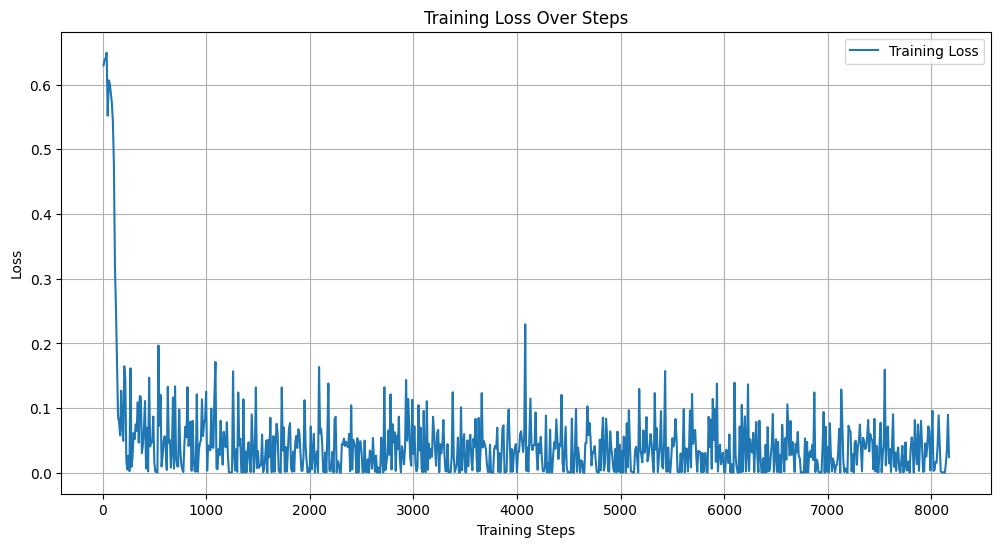

In [ ]:
import matplotlib.pyplot as plt

# Safely extracting data from the metrics, ensuring the key exists
steps = [entry['step'] for entry in metrics if 'loss' in entry]
losses = [entry['loss'] for entry in metrics if 'loss' in entry]
grad_norms = [entry['grad_norm'] for entry in metrics if 'grad_norm' in entry]
learning_rates = [entry['learning_rate'] for entry in metrics if 'learning_rate' in entry]

# Plotting training loss
plt.figure(figsize=(12, 6))
plt.plot(steps, losses, label='Training Loss')
plt.title('Training Loss Over Steps')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

**Gradient Norms Plot**

Gradient norms provide insight into the updates being made to the model’s weights. Monitoring gradient norms can help in diagnosing issues with training dynamics, such as exploding or vanishing gradients.

*Interpretation:*
Stable and moderate gradient norms are typically a good sign, suggesting that the model is learning without numerical instability. Very high values might indicate exploding gradients, while values approaching zero could signal vanishing gradients, both of which can adversely affect training.

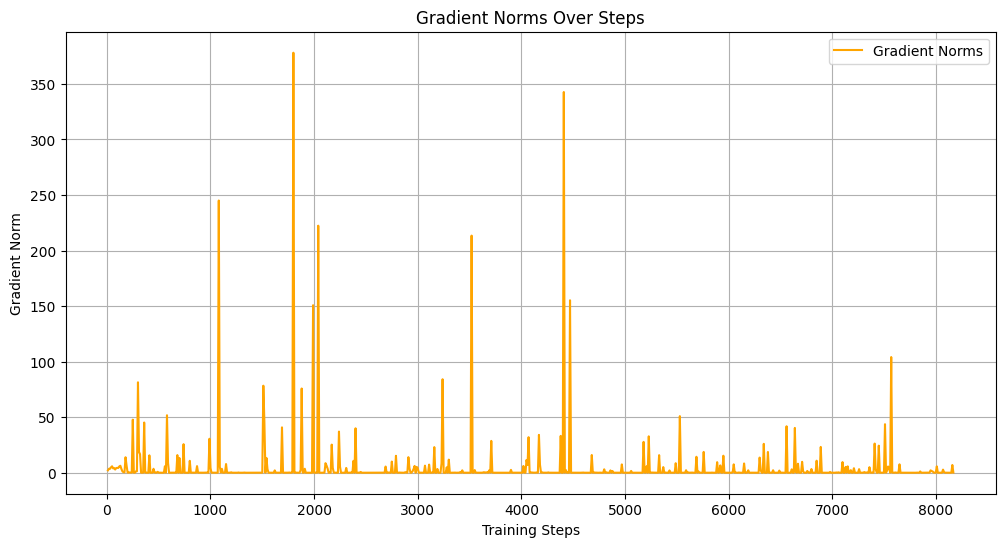

In [ ]:
# Plotting gradient norms (optional)
if grad_norms:  # Check if the list is not empty
    plt.figure(figsize=(12, 6))
    plt.plot(steps, grad_norms, label='Gradient Norms', color='orange')
    plt.title('Gradient Norms Over Steps')
    plt.xlabel('Training Steps')
    plt.ylabel('Gradient Norm')
    plt.legend()
    plt.grid(True)
    plt.show()

**Learning Rate Plot**

This plot tracks changes in the learning rate over the course of training. Many training regimes adjust the learning rate dynamically—a practice known as learning rate scheduling—to improve training efficiency and model performance.

*Interpretation:*

The plot can help verify that the learning rate scheduler is behaving as expected. Gradual decreases or step-wise reductions in the learning rate can help in avoiding local minima and achieving better convergence.


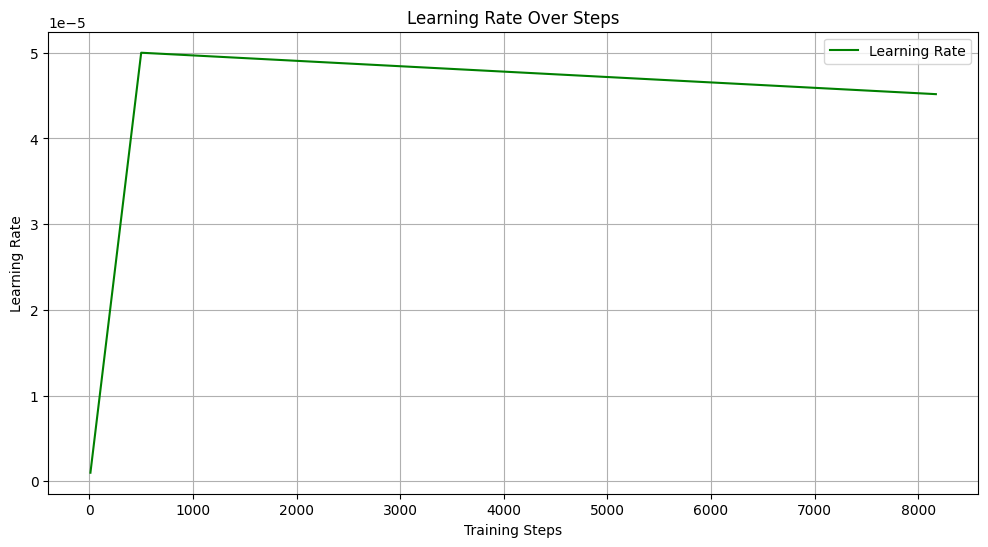

In [ ]:
# Plotting learning rate (optional)
if learning_rates:  # Check if the list is not empty
    plt.figure(figsize=(12, 6))
    plt.plot(steps, learning_rates, label='Learning Rate', color='green')
    plt.title('Learning Rate Over Steps')
    plt.xlabel('Training Steps')
    plt.ylabel('Learning Rate')
    plt.legend()
    plt.grid(True)
    plt.show()